In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import datetime
import os

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers, constraints


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
df = pd.read_csv('Dataset_clean.csv', index_col=[0])

C:\Users\camer\anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
col_names = [col.replace(' ', '') for col in df.columns]
df.columns = col_names
df.head()

,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
DestinationPort,,,,,,,,,,,,,,,,,,,,,
54865.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
55054.0,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
55055.0,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
46236.0,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,6.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
54863.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [4]:
#remove target data with low sample count
#show stats
df = df.replace(['Heartbleed', 'Web_Attack_Sql_Injection', 'Infiltration'], np.nan)
df = df.dropna()

In [5]:
#Creation of a second target label column grouping normal data and attack data
df['Attack'] = np.where(df['Label'] == 'BENIGN', 0, 1)

attack_data = {'BENIGN': 'benign', 
            'DoS_Hulk': 'dos',
            'PortScan': 'probe', 
            'DDoS': 'ddos',
            'DoS_GoldenEye': 'dos',
            'FTPPatator': 'brute_force',
            'SSHPatator': 'brute_force', 
            'DoS_slowloris': 'dos', 
            'DoS_Slowhttptest': 'dos',
            'Bot': 'botnet',
            'Web_Attack_Brute_Force': 'web_based_attack', 
            'Web_Attack_XSS': 'web_based_attack'}

# Creation of a third target label column specifying grouped attacks
df['Label_Category'] = df['Label'].map(lambda x: attack_data[x])

In [6]:
df['Label'].value_counts()

BENIGN                    2035505
DoS_Hulk                   171509
DDoS                       128005
PortScan                    57305
DoS_GoldenEye               10279
FTPPatator                   5480
DoS_slowloris                5289
DoS_Slowhttptest             5176
SSHPatator                   3071
Bot                          1943
Web_Attack_Brute_Force       1445
Web_Attack_XSS                652
Name: Label, dtype: int64

In [7]:
df['Label_Category'].value_counts()

benign              2035505
dos                  192253
ddos                 128005
probe                 57305
brute_force            8551
web_based_attack       2097
botnet                 1943
Name: Label_Category, dtype: int64

In [8]:
df['Attack'].value_counts()

0    2035505
1     390154
Name: Attack, dtype: int64

Text(0.5, 1.0, 'Binary representation of data')

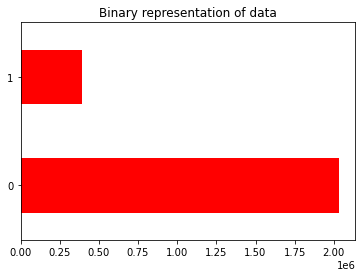

In [9]:
train_attacks = df['Attack'].value_counts()
train_attacks.plot(kind='barh', color='red')
plt.title('Binary representation of data')

In [10]:
data_labels = ['Label', 'Label_Category', 'Attack']

In [11]:
X = df.drop(data_labels, axis=1)
y = df[data_labels]

In [12]:
column_names = np.array(list(X))
to_drop = []
for x in column_names:
    size = X.groupby([x]).size()
    # check for columns that only take one value
    if (len(size.unique()) == 1):
        to_drop.append(x)
to_drop

['BwdPSHFlags',
 'BwdURGFlags',
 'FwdAvgBytes/Bulk',
 'FwdAvgPackets/Bulk',
 'FwdAvgBulkRate',
 'BwdAvgBytes/Bulk',
 'BwdAvgPackets/Bulk',
 'BwdAvgBulkRate']

In [13]:
X = X.drop(to_drop, axis=1)
dataset_hold = df.drop(to_drop, axis=1)

In [14]:
del df

In [15]:
y_label = y.Label
y_label_category = y.Label_Category
y_attack = y.Attack
x1,x2,x3=X,X,X


for i in range(0,3):
    
    if i ==0:
        y = y_label
        X =x1
    elif i==1:
        y=y_label_category
        X=x2
    else:
        y=y_attack
        X=x3

    LE = LabelEncoder()

    LE.fit(y)
    y = LE.transform(y)
    
 

    sel = SelectFromModel(RandomForestClassifier(n_estimators = 50 , verbose=2))
    sel.fit(X, y)


    sel.get_support()

    selected_feat= X.columns[(sel.get_support())]
    input_layers = len(selected_feat)
    print(selected_feat, len(selected_feat))

    X = sel.transform(X)
    #X_val = sel.transform(X_val)

    if i==0:
        y_Label = y

    elif i==1:
        y_Label_Category = y
    else:
        y_Attack = y



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 11.0min finished


Index(['TotalFwdPackets', 'TotalBackwardPackets', 'TotalLengthofFwdPackets',
       'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMean',
       'FwdPacketLengthStd', 'BwdPacketLengthMax', 'BwdPacketLengthMean',
       'BwdPacketLengthStd', 'FwdIATStd', 'FwdIATMax', 'FwdHeaderLength',
       'BwdHeaderLength', 'MaxPacketLength', 'PacketLengthMean',
       'PacketLengthStd', 'PacketLengthVariance', 'AveragePacketSize',
       'AvgBwdSegmentSize', 'SubflowFwdPackets', 'SubflowFwdBytes',
       'SubflowBwdPackets', 'SubflowBwdBytes', 'act_data_pkt_fwd', 'IdleMean'],
      dtype='object') 26


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 11.3min finished


Index(['TotalFwdPackets', 'TotalLengthofFwdPackets', 'TotalLengthofBwdPackets',
       'FwdPacketLengthMax', 'FwdPacketLengthMean', 'BwdPacketLengthMean',
       'BwdPacketLengthStd', 'FlowIATStd', 'FlowIATMax', 'FwdIATStd',
       'MaxPacketLength', 'PacketLengthMean', 'PacketLengthStd',
       'PacketLengthVariance', 'AveragePacketSize', 'AvgFwdSegmentSize',
       'AvgBwdSegmentSize', 'SubflowFwdPackets', 'SubflowFwdBytes',
       'SubflowBwdBytes', 'Init_Win_bytes_backward', 'act_data_pkt_fwd',
       'IdleMean'],
      dtype='object') 23


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.9s remaining:    0.0s


building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 10.5min finished


Index(['TotalFwdPackets', 'TotalLengthofFwdPackets', 'TotalLengthofBwdPackets',
       'FwdPacketLengthMax', 'BwdPacketLengthMax', 'BwdPacketLengthMean',
       'BwdPacketLengthStd', 'FlowIATMax', 'FwdIATStd', 'FwdHeaderLength',
       'MaxPacketLength', 'PacketLengthMean', 'PacketLengthStd',
       'PacketLengthVariance', 'AveragePacketSize', 'AvgBwdSegmentSize',
       'SubflowFwdPackets', 'SubflowFwdBytes', 'SubflowBwdBytes',
       'min_seg_size_forward', 'IdleMax'],
      dtype='object') 21


In [16]:
#sequential(X, ,  )

In [17]:
np.unique(y_Label)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [18]:
np.unique(y_Label_Category)

array([0, 1, 2, 3, 4, 5, 6])

In [19]:
np.unique(y_attack)

array([0, 1])

In [20]:
np.unique(y)

array([0, 1], dtype=int64)

-----------------------------------------------------------------------------------------------
Random forrest classifier, training for loop 1 ... this loop contains 12 target labels...
-----------------------------------------------------------------------------------------------
Original labels accuracy =  0.99
                        precision    recall  f1-score   support

                Benign       0.99      1.00      0.99    407101
              DoS_Hulk       1.00      0.02      0.04       388
                  DDos       1.00      1.00      1.00     25601
              PortScan       0.99      0.83      0.91      2056
         DoS_GoldenEye       1.00      0.95      0.97     34302
            FTPPatator       0.89      0.76      0.82      1035
         DoS_slowlorus       0.98      0.57      0.72      1058
      DoS_Slowhttptest       0.99      0.99      0.99      1096
            SSHPatator       0.98      0.98      0.98     11461
                   Bot       1.00      0.93 

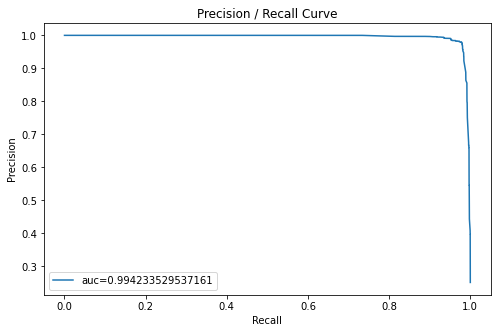

Average PR Score 0.994233529537161


In [21]:
def Randomforrest(X, y_Label, y_Label_Category, y_attack):
    from sklearn.metrics import precision_score
    import warnings
    x1,x2,x3=X,X,X
    
    original_target_names=['Benign', 'DoS_Hulk', 'DDos', 'PortScan', 'DoS_GoldenEye', 'FTPPatator', 'DoS_slowlorus', 'DoS_Slowhttptest', 'SSHPatator', 'Bot', 'Web_Attack_Brute_Force', 'Web_Attack_XSS']
    label_cat_names =['Benign', 'dos', 'ddos', 'probe','brute_force', 'web_based_attack', 'botnet']
    label_attack_names = ['Benign', 'Attack']
   

    warnings.filterwarnings('ignore')
    
    loop_no =1
    
    for i in range(0,3):

            if i ==0:
                y = y_Label
                X =x1

            elif i==1:
                y=y_Label_Category
                X=x2

            elif i==2:
                y=y_attack
                X=x3


            X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

            X_test, X_val, y_test, y_val = train_test_split(X_hold, y_hold, test_size=0.5, random_state=0, stratify=y_hold)

            min_max_scaler = MinMaxScaler().fit(X_train)

            # Apply normalisation to dataset
            X_train = min_max_scaler.transform(X_train)
            X_val = min_max_scaler.transform(X_val)
            X_test = min_max_scaler.transform(X_test)


            print('-----------------------------------------------------------------------------------------------')
            print(f'Random forrest classifier, training for loop {loop_no} ... this loop contains {len(np.unique(y))} target labels...')
            print('-----------------------------------------------------------------------------------------------')


            clf = RandomForestClassifier(n_estimators=32, max_depth=8, random_state=0, verbose=0, max_features='auto')

            y_pred = clf.fit(X_train, y_train).predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)

            if i == 0:
                print(f'Original labels accuracy =  {"{:.2f}".format(accuracy)}')
                print(classification_report(y_test, y_pred, target_names=original_target_names))
            elif i == 1:
                print(f'Category labels accuracy =  {"{:.2f}".format(accuracy)}')
                print(classification_report(y_test, y_pred, target_names=label_cat_names))
            elif i == 2:
                print(f'Binary labels accuracy =  {"{:.2f}".format(accuracy)}')
                print(classification_report(y_test, y_pred, target_names=label_attack_names))


                clf_prob = clf.predict_proba(X_test)
                clf_prob = clf_prob[:, 1] #keep probabilites for only positive outcomes

                clf_precision, clf_recall, _ = precision_recall_curve(y_test, clf_prob)
                pr_auc = average_precision_score(y_test, clf_prob, average='weighted')

                clf_f1, clf_auc = f1_score(y_test, y_pred), auc(clf_recall, clf_precision)

                print('Decision tree: f1=%.3f auc=%.3f' % (clf_f1, clf_auc))

                plt.figure(figsize=(8, 5))
                plt.plot(clf_recall, clf_precision, label='auc={}'.format(pr_auc))
                plt.title('Precision / Recall Curve')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.legend(loc='lower left')
                plt.show()

                print('Average PR Score {}'.format(pr_auc))
            
        
Randomforrest(X, y_Label, y_Label_Category, y_attack)

-----------------------------------------------------------------------------------------------
Decision tree classifier, this itteration contains 12 target labels...
-----------------------------------------------------------------------------------------------
Original labels accuracy =  0.97
                        precision    recall  f1-score   support

                Benign       1.00      0.96      0.98    407101
              DoS_Hulk       0.02      0.86      0.05       388
                  DDos       1.00      1.00      1.00     25601
              PortScan       0.98      0.98      0.98      2056
         DoS_GoldenEye       0.99      0.99      0.99     34302
            FTPPatator       0.94      0.98      0.96      1035
         DoS_slowlorus       0.99      0.99      0.99      1058
      DoS_Slowhttptest       0.91      1.00      0.95      1096
            SSHPatator       0.91      1.00      0.95     11461
                   Bot       0.96      0.96      0.96       614

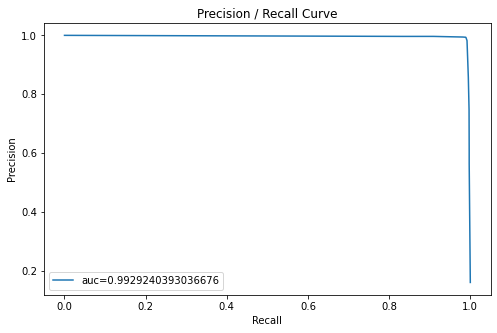

Average PR Score 0.9929240393036676


In [22]:
def DecTree(X, y_Label, y_Label_Category, y_attack):
    x1,x2,x3=X,X,X
    original_target_names=['Benign', 'DoS_Hulk', 'DDos', 'PortScan', 'DoS_GoldenEye', 'FTPPatator', 'DoS_slowlorus', 'DoS_Slowhttptest', 'SSHPatator', 'Bot', 'Web_Attack_Brute_Force', 'Web_Attack_XSS']
    label_cat_names =['Benign', 'dos', 'ddos', 'probe','brute_force', 'web_based_attack', 'botnet']
    label_attack_names = ['Benign', 'Attack']

    label_f1_results=[]
    cat_f1_results=[]
    bi_f1_results=[]

    label_prec_results=[]
    cat_prec_results=[]
    bi_prec_results=[]
    from sklearn.tree import DecisionTreeClassifier
    

    for i in range(0,3):

            if i ==0:
                y = y_Label
                X =x1

            elif i==1:
                y=y_Label_Category
                X=x2

            elif i==2:
                y=y_attack
                X=x3


            X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

            X_test, X_val, y_test, y_val = train_test_split(X_hold, y_hold, test_size=0.5, random_state=0, stratify=y_hold)

            min_max_scaler = MinMaxScaler().fit(X_train)

            # Apply normalisation to dataset
            X_train = min_max_scaler.transform(X_train)
            X_val = min_max_scaler.transform(X_val)
            X_test = min_max_scaler.transform(X_test)


            print('-----------------------------------------------------------------------------------------------')
            print(f'Decision tree classifier, this itteration contains {len(np.unique(y))} target labels...')
            print('-----------------------------------------------------------------------------------------------')


            clf = DecisionTreeClassifier(random_state=0, class_weight="balanced")
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            if i == 0:
                print(f'Original labels accuracy =  {"{:.2f}".format(accuracy)}')
                print(classification_report(y_test, y_pred, target_names=original_target_names))
            elif i == 1:
                print(f'Category labels accuracy =  {"{:.2f}".format(accuracy)}')
                print(classification_report(y_test, y_pred, target_names=label_cat_names))
            elif i == 2:
                print(f'Binary labels accuracy =  {"{:.2f}".format(accuracy)}')
                print(classification_report(y_test, y_pred, target_names=label_attack_names))


                clf_prob = clf.predict_proba(X_test)
                clf_prob = clf_prob[:, 1] #keep probabilites for only positive outcomes

                clf_precision, clf_recall, _ = precision_recall_curve(y_test, clf_prob)
                pr_auc = average_precision_score(y_test, clf_prob, average='weighted')

                clf_f1, clf_auc = f1_score(y_test, y_pred), auc(clf_recall, clf_precision)

                print('Decision tree: f1=%.3f auc=%.3f' % (clf_f1, clf_auc))

                plt.figure(figsize=(8, 5))
                plt.plot(clf_recall, clf_precision, label='auc={}'.format(pr_auc))
                plt.title('Precision / Recall Curve')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.legend(loc='lower left')
                plt.show()

                print('Average PR Score {}'.format(pr_auc))

DecTree(X, y_Label, y_Label_Category, y_attack)                  

-----------------------------------------------------------------------------------------------
Sequential NN, training loop 1 ... this loop contains 12 target labels...
-----------------------------------------------------------------------------------------------
Train on 1455395 samples, validate on 485132 samples
Epoch 1/80
1455395/1455395 [==============================] - 4s 3us/sample - loss: 0.4519 - accuracy: 0.9058 - val_loss: 0.3367 - val_accuracy: 0.9225
Epoch 2/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.3250 - accuracy: 0.9215 - val_loss: 0.2893 - val_accuracy: 0.9245
Epoch 3/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.2895 - accuracy: 0.9238 - val_loss: 0.2616 - val_accuracy: 0.9270
Epoch 4/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.2674 - accuracy: 0.9301 - val_loss: 0.2452 - val_accuracy: 0.9351
Epoch 5/80
1455395/1455395 [==============================] - 3s 2us/samp

1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1442 - accuracy: 0.9528 - val_loss: 0.1330 - val_accuracy: 0.9549
Epoch 17/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1393 - accuracy: 0.9532 - val_loss: 0.1278 - val_accuracy: 0.9537
Epoch 18/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1346 - accuracy: 0.9537 - val_loss: 0.1238 - val_accuracy: 0.9556
Epoch 19/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1308 - accuracy: 0.9544 - val_loss: 0.1198 - val_accuracy: 0.9561
Epoch 20/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1274 - accuracy: 0.9563 - val_loss: 0.1165 - val_accuracy: 0.9570
Epoch 21/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1243 - accuracy: 0.9588 - val_loss: 0.1153 - val_accuracy: 0.9665
Epoch 22/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1220 - 

1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1306 - accuracy: 0.9491 - val_loss: 0.1206 - val_accuracy: 0.9506
Epoch 37/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1294 - accuracy: 0.9493 - val_loss: 0.1200 - val_accuracy: 0.9507
Epoch 38/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1286 - accuracy: 0.9499 - val_loss: 0.1176 - val_accuracy: 0.9501
Epoch 39/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1276 - accuracy: 0.9503 - val_loss: 0.1174 - val_accuracy: 0.9526
Epoch 40/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1274 - accuracy: 0.9507 - val_loss: 0.1156 - val_accuracy: 0.9506
Epoch 41/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1265 - accuracy: 0.9511 - val_loss: 0.1151 - val_accuracy: 0.9502
Epoch 42/80
1455395/1455395 [==============================] - 3s 2us/sample - loss: 0.1257 - 

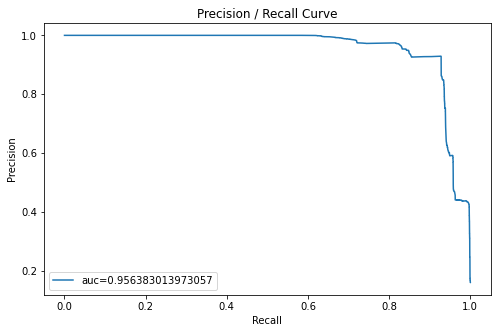

Average PR Score 0.956383013973057


In [23]:
def Sequential(X, y_Label, y_Label_Category, y_attack):
    
    original_target_names=['Benign', 'DoS_Hulk', 'DDos', 'PortScan', 'DoS_GoldenEye', 'FTPPatator', 'DoS_slowlorus', 'DoS_Slowhttptest', 'SSHPatator', 'Bot', 'Web_Attack_Brute_Force', 'Web_Attack_XSS']
    label_cat_names =['Benign', 'dos', 'ddos', 'probe','brute_force', 'web_based_attack', 'botnet']
    label_attack_names = ['Benign', 'Attack']
    
    x1,x2,x3=X,X,X
    loop_no=1
    epoch = 80
    batch = 1000
    
    
    for i in range(0,3): 

        if i ==0:
            y = y_Label
            X =x1
            out_layer = len(np.unique(y))
            H_layer = 75
        elif i==1:
            y=y_Label_Category
            X=x2
            out_layer = len(np.unique(y))
            H_layer = 73
        elif i==2:
            y=y_attack
            X=x3
            out_layer = len(np.unique(y))
            H_layer = 40
            

        print('-----------------------------------------------------------------------------------------------')
        print(f'Sequential NN, training loop {loop_no} ... this loop contains {len(np.unique(y))} target labels...')
        print('-----------------------------------------------------------------------------------------------')

        X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

        X_test, X_val, y_test, y_val = train_test_split(X_hold, y_hold, test_size=0.5, random_state=0, stratify=y_hold)


        # Normalise
        min_max_scaler = MinMaxScaler().fit(X_train)

        # Apply normalisation to dataset
        X_train = min_max_scaler.transform(X_train)
        X_val = min_max_scaler.transform(X_val)
        X_test = min_max_scaler.transform(X_test)


        model = tf.keras.models.Sequential([

        tf.keras.layers.Flatten(input_shape=(input_layers,)), #input, value set by feature selection 
        tf.keras.layers.Dense(H_layer, activation='relu'), #Hidden layer
        tf.keras.layers.Dropout(0.2), #dropou
        tf.keras.layers.Dense(out_layer, activation='softmax') #Layer changes depending on amount of target variables
        ])

        model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


        import os

        log_dir = os.path.join(
        "train_logs",
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
        )

        # TF callback that sets up TensorBoard with training logs.
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        # TF callback that stops training when best value of validationi loss function is reached. It also
        # restores weights from the best training iteration.
        eary_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)



        history = model.fit(X_train,
            y_train,
            epochs=epoch,
            batch_size = batch,
            validation_data=(X_val, y_val),
            verbose=1)
            #callbacks=[tensorboard_callback, eary_stop_callback])

        loop_no = loop_no + 1

        y_pred = model.predict_classes(X_test, verbose=0)
        accuracy = accuracy_score(y_test, y_pred)

        if i == 0:
            print(f'Original labels accuracy =  {"{:.2f}".format(accuracy)}')
            print(classification_report(y_test, y_pred, target_names=original_target_names))
        elif i == 1:
            print(f'Category labels accuracy =  {"{:.2f}".format(accuracy)}')
            print(classification_report(y_test, y_pred, target_names=label_cat_names))
        elif i == 2:
            print(f'Binary labels accuracy =  {"{:.2f}".format(accuracy)}')
            print(classification_report(y_test, y_pred, target_names=label_attack_names))

            prob = model.predict_proba(X_test)
            prob = prob[:, 1] #keep probabilites for only positive outcomes

            model_precision, model_recall, _ = precision_recall_curve(y_test, prob)
            pr_auc = average_precision_score(y_test, prob, average='weighted')

            NN_f1, NN_auc = f1_score(y_test, y_pred), auc(model_recall, model_precision)

            print('Sequential: f1=%.3f auc=%.3f' % (NN_f1, NN_auc))

            plt.figure(figsize=(8, 5))
            plt.plot(model_recall, model_precision, label='auc={}'.format(pr_auc))
            plt.title('Precision / Recall Curve')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend(loc='lower left')
            plt.show()

            print('Average PR Score {}'.format(pr_auc))
            
            

    
Sequential(X, y_Label, y_Label_Category, y_attack)


-----------------------------------------------------------------------------------------------
Gaussian Naive Bayes classifier, training for loop 1 ... this loop contains 12 target labels...
-----------------------------------------------------------------------------------------------
Number of mislabeled points out of a total 485132 points : 383835

Original labels accuracy =  0.21
                        precision    recall  f1-score   support

                Benign       1.00      0.07      0.14    407101
              DoS_Hulk       0.00      0.44      0.00       388
                  DDos       0.93      0.95      0.94     25601
              PortScan       0.06      0.99      0.11      2056
         DoS_GoldenEye       0.86      0.89      0.87     34302
            FTPPatator       0.00      0.68      0.01      1035
         DoS_slowlorus       0.05      0.60      0.08      1058
      DoS_Slowhttptest       0.29      1.00      0.45      1096
            SSHPatator       0.60  

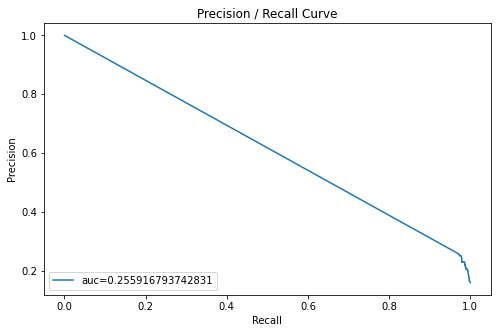

Average PR Score 0.255916793742831


In [24]:
def GNB(X, y_Label, y_Label_Category, y_attack):
    
    loop_no=1
    original_target_names=['Benign', 'DoS_Hulk', 'DDos', 'PortScan', 'DoS_GoldenEye', 'FTPPatator', 'DoS_slowlorus', 'DoS_Slowhttptest', 'SSHPatator', 'Bot', 'Web_Attack_Brute_Force', 'Web_Attack_XSS']
    label_cat_names =['Benign', 'dos', 'ddos', 'probe','brute_force', 'web_based_attack', 'botnet']
    label_attack_names = ['Benign', 'Attack']
    
    for i in range(0,3): 

        if i ==0:
            y = y_Label
            X =x1

        elif i==1:
            y=y_Label_Category
            X=x2

        elif i==2:
            y=y_attack
            X=x3

        print('-----------------------------------------------------------------------------------------------')
        print(f'Gaussian Naive Bayes classifier, training for loop {loop_no} ... this loop contains {len(np.unique(y))} target labels...')
        print('-----------------------------------------------------------------------------------------------')

        X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

        X_test, X_val, y_test, y_val = train_test_split(X_hold, y_hold, test_size=0.5, random_state=0, stratify=y_hold)

        min_max_scaler = MinMaxScaler().fit(X_train)

        # Apply normalisation to dataset
        X_train = min_max_scaler.transform(X_train)
        X_val = min_max_scaler.transform(X_val)
        X_test = min_max_scaler.transform(X_test)


        gnb = GaussianNB()
        y_pred = gnb.fit(X_train, y_train).predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        print("Number of mislabeled points out of a total %d points : %d"
              % (X_test.shape[0], (y_test != y_pred).sum()))
        print('')

        if i == 0:
            print(f'Original labels accuracy =  {"{:.2f}".format(accuracy)}')
            print(classification_report(y_test, y_pred, target_names=original_target_names))
        elif i == 1:
            print(f'Category labels accuracy =  {"{:.2f}".format(accuracy)}')
            print(classification_report(y_test, y_pred, target_names=label_cat_names))
        elif i == 2:
            print(f'Binary labels accuracy =  {"{:.2f}".format(accuracy)}')
            print(classification_report(y_test, y_pred, target_names=label_attack_names))


            gnb_prob = gnb.predict_proba(X_test)
            gnb_prob = gnb_prob[:, 1] #keep probabilites for only positive outcomes

            gnb_precision, gnb_recall, _ = precision_recall_curve(y_test, gnb_prob)
            pr_auc = average_precision_score(y_test, gnb_prob, average='weighted')

            gnb_f1, gnb_auc = f1_score(y_test, y_pred), auc(gnb_recall, gnb_precision)

            print('GaussianNB: f1=%.3f auc=%.3f' % (gnb_f1, gnb_auc))

            plt.figure(figsize=(8, 5))
            plt.plot(gnb_recall, gnb_precision, label='auc={}'.format(pr_auc))
            plt.title('Precision / Recall Curve')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.legend(loc='lower left')
            plt.show()

            print('Average PR Score {}'.format(pr_auc))
        
GNB(X, y_Label, y_Label_Category, y_attack)       


In [25]:
def SVM(X, y_Label, y_Label_Category, y_attack):
    
    original_target_names=['Benign', 'DoS_Hulk', 'DDos', 'PortScan', 'DoS_GoldenEye', 'FTPPatator', 'DoS_slowlorus', 'DoS_Slowhttptest', 'SSHPatator', 'Bot', 'Web_Attack_Brute_Force', 'Web_Attack_XSS']
    label_cat_names =['Benign', 'dos', 'ddos', 'probe','brute_force', 'web_based_attack', 'botnet']
    label_attack_names = ['Benign', 'Attack']
    from sklearn.svm import SVC
    loop_no=1
    
    for i in range(0,3): 

        if i ==0:
            y = y_Label
            X =x1

        elif i==1:
            y=y_Label_Category
            X=x2

        elif i==2:
            y=y_attack
            X=x3

        print('-----------------------------------------------------------------------------------------------')
        print(f'Support vector machine classifier, training for loop {loop_no} ... this loop contains {len(np.unique(y))} target labels...')
        print('-----------------------------------------------------------------------------------------------')

        X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

        X_test, X_val, y_test, y_val = train_test_split(X_hold, y_hold, test_size=0.5, random_state=0, stratify=y_hold)

        min_max_scaler = MinMaxScaler().fit(X_train)

        # Apply normalisation to dataset
        X_train = min_max_scaler.transform(X_train)
        X_val = min_max_scaler.transform(X_val)
        X_test = min_max_scaler.transform(X_test)
        
        c=0.1
        gamma=1
        
        model = SVC(C=c, gamma=gamma, kernel='rbf')
        model.fit(X_train, y_train)
        
        # print prediction results
        predictions = model.predict(X_test)
        print(classification_report(y_test, predictions))
        
        
        
        

        if i == 0:
            print(f'Original labels accuracy =  {"{:.2f}".format(accuracy)}')
            print(classification_report(y_test, y_pred, target_names=original_target_names))
        elif i == 1:
            print(f'Category labels accuracy =  {"{:.2f}".format(accuracy)}')
            print(classification_report(y_test, y_pred, target_names=label_cat_names))
        elif i == 2:
            print(f'Binary labels accuracy =  {"{:.2f}".format(accuracy)}')
            print(classification_report(y_test, y_pred, target_names=label_attack_names))

#SVM(X, y_Label, y_Label_Category, y_attack)